In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import display
import pickle

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# make_split.py
def get_imgs(name='parking3_split'):
    path = f'../../Data/{name}/train/'
    temp = os.listdir(path)
    imgs = []
    for img in temp:
        if 'm2det' not in img:
            if 'split' not in img:
                imgs.append(path + img)
    return imgs

def split_images(name='parking3_split', save_path=None):
    img_names = get_imgs(name)
    if save_path is None:
        tmp = img_names[0]
        index = len(tmp) - tmp[::-1].find('/')
        save_path = tmp[:index]
        
    splits_w = [[.0, .5], [.25, .75], [.5, 1.]]
    splits_h = [[.0, .5], [.25, .75], [.5, 1.]]    
    
    for num, image in enumerate(img_names):
        im = imageio.imread(image)
        h, w = im.shape[:2]
        
        
        name = image.split('/')[-1]
        for i, s_h in enumerate(splits_h):
            for j, s_w in enumerate(splits_w):
                img = im[int(h*s_h[0]):int(h*s_h[1]), int(w*s_w[0]):int(w*s_w[1]), :]
                new_w = int(s_w[0]*w)
                new_h = int(s_h[0]*h)
                
                save_name = os.path.join(save_path, f'{num}_{new_h}_{new_w}_split_{name}')
                
                imageio.imwrite(save_name, img)
    
split_images()

In [91]:
# utils.py
def clean_labels(locs):
    clean_list = {}
    for k, v in locs.items():
        img_path = '../../' + k
        img = imageio.imread(img_path)
        h, w = img.shape[:2]
        clean_list[img_path] = []
        
        for x in v:
            if x[0] < 0:   x[0] = 0
            if x[1] < 0:   x[1] = 0
            if x[2] >= w:  x[2] = w-1
            if x[3] >= h:  x[3] = h-1
            clean_list[img_path].append(x)
            
    return clean_list
        
def corner_to_center(locs):
    center_list = {}
    for k, v in locs.items():
        center_list[k] = []
        for x in v:
            center_list[k].append([(x[0]+x[2]) // 2,
                                (x[1]+x[3]) // 2,
                                 x[2] - x[0],
                                 x[3] - x[1]])
    return center_list

def center_to_corner(locs):
    corner_list = {}
    for k, v in locs.items():
        corner_list[k] = []
        for x in v:
            corner_list[k].append([x[0] - x[2]//2,
                                x[1] - x[3]//2,
                                x[0] + x[2]//2,
                                x[1] + x[3]//2])
    return corner_list

def get_corner(loc):
    return [loc[0] - loc[2]//2,
            loc[1] - loc[3]//2,
            loc[0] + loc[2]//2,
            loc[1] + loc[3]//2]

def min_euclid(coord, locs):
    x = coord[0]
    y = coord[1]
    min_dist = 1e8
    
    for loc in locs:
        dist = (x - loc[0])**2 + (y - loc[1])**2
        if dist < min_dist:
            min_dist = dist
            min_loc = loc
    return min_loc

def IOU(coord1, coord2, area_inter=False):
    x_left = max(coord1[0], coord2[0])
    y_top = max(coord1[1], coord2[1])
    x_right = min(coord1[2], coord2[2])
    y_bottom = min(coord1[3], coord2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return .0
    
    inter_area = (x_right - x_left) * (y_bottom - y_top)
    if area_inter:
        return inter_area
    coord1_area = (coord1[2] - coord1[0]) * (coord1[3] - coord1[1])
    coord2_area = (coord2[2] - coord2[0]) * (coord2[3] - coord2[1])
    
    iou = inter_area / float(coord1_area + coord2_area - inter_area)

    return iou

In [99]:
# combine_splits.py
def adjust_dims(locs):
    names = list(locs.keys())
    tmp = names[0]
    dir_index = len(tmp) - tmp[::-1].find('/')
    names.sort()
    
    for name in names:
        if 'split' in name[dir_index:]:
            loc_new = []
            loc = locs[name]
            img_name = name[dir_index:]
            h, w = [int(x) for x in img_name.split('_')[1:3]]
            
            for x in loc:
                loc_new.append([x[0]+w, x[1]+h, x[2]+w, x[3]+h])
            locs[name] = loc_new
    return locs


def merge_images(locs):
    names = list(locs.keys())
    tmp = names[0]
    dir_index = len(tmp) - tmp[::-1].find('/')
    dir_name = tmp[:dir_index]
    
    m_locs = {}
    for name in names:
        img_name = name[dir_index:]
        
        if 'split' in img_name:
            ind = img_name.find('split_') + 6
            orig_name = img_name[ind:]
            img = dir_name+orig_name
            
            if img in m_locs:
                m_locs[img] = m_locs[img] + locs[name]
            else:
                m_locs[img] = locs[name]
    
    names = list(m_locs.keys())
    final_locs = {}
    for name in names:
        final_locs[name] = m_locs[name] + locs[name]
        
    return final_locs
    

def merge_labels(locs, thresh):
    final_locs = {}
    for k, v in locs.items():
        final_locs[k] = []
        
        for x in v:
            if len(final_locs[k]) == 0:
                final_locs[k].append(x)
            
            min_loc = min_euclid(x, final_locs[k])
            
            x_corner = get_corner(x)
            min_loc_corner = get_corner(min_loc)
            
            iou = IOU(x_corner, min_loc_corner)
            if iou < thresh:
                final_locs[k].append(x)

    return final_locs
    

def final_clean(locs, thresh=0.7):
    final_locs = {}
    for k, v in locs.items():            
        final_locs[k] = v
        overlap = []
        for i, x in enumerate(v):
            if x in overlap:
                continue
            
            x_corner = get_corner(x)
            
            for j, y in enumerate(v):
                if y == x:
                    continue
                y_corner = get_corner(y)
                area = IOU(x_corner, y_corner, area_inter=True)
                if area != 0.0:
                    if area/(y[2]*y[3]) > thresh:
                        overlap.append(y)
                        final_locs[k].remove(y)
    return final_locs
    
def combine_splits(name='parking3_split', thresh1=0.3, thresh2=0.5):
    with open(f'../../Data/labels/{name}_split.txt', 'rb') as f:
        locs = pickle.load(f)

    locs = adjust_dims(locs)
    locs = merge_images(locs)
    locs = clean_labels(locs)
    locs = corner_to_center(locs)
    locs = merge_labels(locs, thresh=thresh1)
    locs = final_clean(locs, thresh=thresh2)
    locs = center_to_corner(locs)
    return locs

locs = combine_splits()

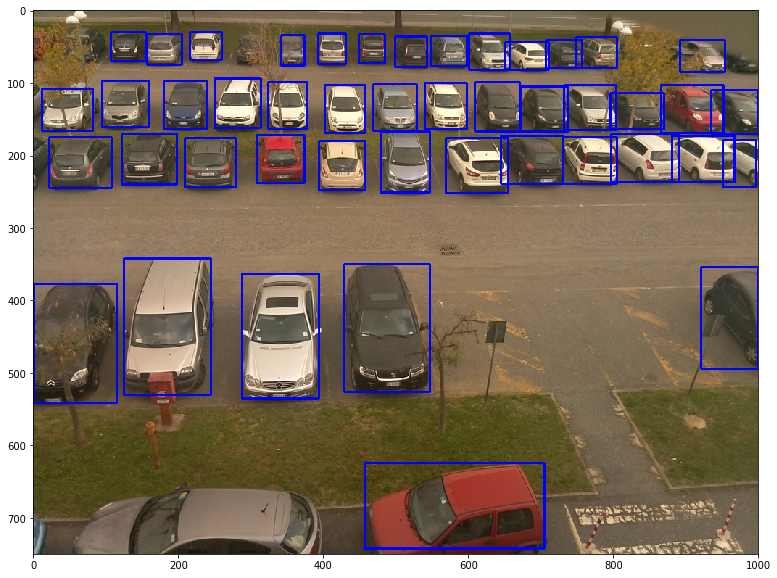

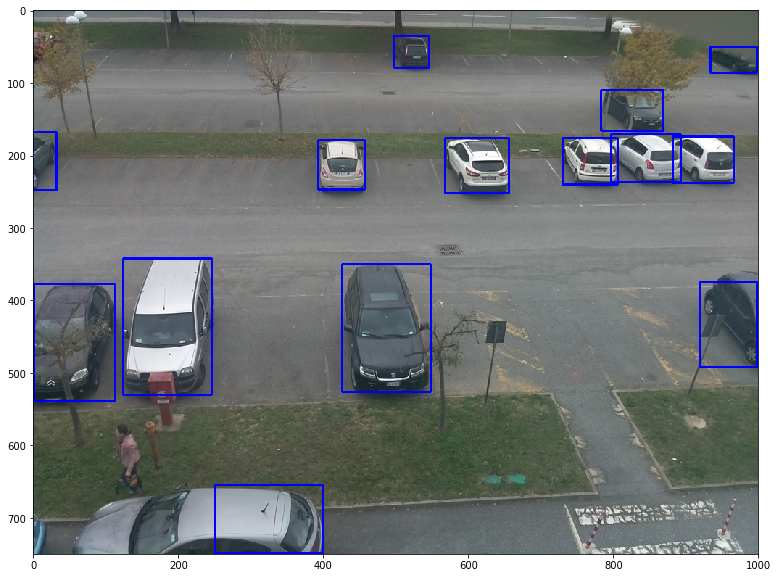

In [100]:
def draw_detection(locs):
    for k, v in locs.items():
        img = imageio.imread(k)
        for x in v:
            cv2.rectangle(img,
                          (x[0], x[1]), (x[2], x[3]),
                          (0,0,255),
                          2)
        plt.figure(figsize=(15,10))
        plt.imshow(img)
        plt.pause(1)
        
draw_detection(locs)

In [41]:
len(locs[list(locs.keys())[1]])

15

In [69]:
get_corner([740, 201, 17, 51])

[732, 176, 748, 226]